# Inteligentná analýza údajov 2019/2020 - Projekt
## Druhá časť - predspracovanie
## Ondrej Jedinák, František Tibenský

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin

from IPython.display import display

pd.options.display.max_colwidth=130
pd.set_option("display.max_columns", None)

In [2]:
personal_data = pd.read_csv("data/personal_train.csv", index_col=0)
data = pd.read_csv("data/other_train.csv", index_col=0)

In [3]:
class ColNameUnifier(TransformerMixin):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        cols=df.columns
        cols_new=[]
        for col in cols:
            cols_new.append(col.replace("-","_"))
        df.rename(columns={i:j for i,j in zip(cols,cols_new)}, inplace=True)
        return df

data=ColNameUnifier().fit_transform(data)
personal_data=ColNameUnifier().fit_transform(personal_data)

Nastavíme konzistentné názvy atribútov pre lepšiu prehľadnosť.

In [4]:
class SpaceRemover(TransformerMixin):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        for col in df:
            if df[col].dtype=='object':
                df[col]=df[col].str.strip()
        return df

class MissingDataUnifier(TransformerMixin):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df=df.replace('?',np.NaN)
        df=df.replace('??',np.NaN)
        return df
    
    
data=MissingDataUnifier().fit_transform(SpaceRemover().fit_transform(data))
personal_data=MissingDataUnifier().fit_transform(SpaceRemover().fit_transform(personal_data))

Odstránime zo všetkých textových atribútov prázdne znaky na začiatku a konci a zmeníme hodnoty s otáznikmi na NaN. Týmto vyriešime problém kedy v niektorých atribútoch boli duplikované hodnoty kvôli nekonzistentným medzerám na začiatku.

In [5]:
display(personal_data.head())
data.head()

,name,address,age,sex,date_of_birth
0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH 53211",58,Male,1961-03-11
1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN 57550",56,Female,1962/11/20
2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",59,Male,11/12/1959
3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",66,Female,1953-03-18
4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 77139",64,Male,1954-12-12


,name,address,race,marital_status,occupation,pregnant,education_num,relationship,skewness_glucose,mean_glucose,capital_gain,kurtosis_glucose,education,fnlwgt,class,std_glucose,income,medical_info,native_country,hours_per_week,capital_loss,workclass
0,Ernest Valles,"698 Miller Gateway Apt. 970\r\nClayside, ND 13457",White,Married-civ-spouse,Adm-clerical,f,10.0,Husband,0.198684,105.859375,0.0,0.222954,Some-college,343789.0,0.0,48.744348,>50K,"{'mean_oxygen':'0.790133779','std_oxygen':'10.13249696','kurtosis_oxygen':'17.68151382','skewness_oxygen':'374.9257754'}",United-States,40.0,0.0,State-gov
1,Michael Kowal,"4784 Walters Extensions\r\nEast Whitney, NH 27458",White,NaN,Sales,F,13.0,Not-in-family,-0.334631,120.453125,0.0,-0.049047,Bachelors,188957.0,0.0,50.982512,<=50K,"{'mean_oxygen':'18.69147157','std_oxygen':'51.21049055','kurtosis_oxygen':'2.541428789','skewness_oxygen':'4.930561896'}",United-States,40.0,0.0,Self-emp-not-inc
2,Mike Rogers,"068 Baker Estates Apt. 300\r\nRoberttown, NV 50205",White,Married-civ-spouse,Sales,f,13.0,Husband,0.030878,117.257812,0.0,0.121774,Bachelors,112283.0,0.0,42.893263,<=50K,"{'mean_oxygen':'1.150501672','std_oxygen':'11.49825164','kurtosis_oxygen':'16.48789423','skewness_oxygen':'320.6702352'}",United-States,55.0,0.0,Private
3,Marvin Cherry,"75326 Odom Drive\r\nNorth Robert, SC 99612",White,Married-civ-spouse,Farming-fishing,f,9.0,Husband,0.636882,99.429688,0.0,0.349696,HS-grad,166416.0,0.0,43.658777,<=50K,"{'mean_oxygen':'0.387123746','std_oxygen':'8.683190316000001','kurtosis_oxygen':'25.389201','skewness_oxygen':'685.06342239999...",United-States,99.0,0.0,Self-emp-not-inc
4,Bernard Williams,"258 Valerie Throughway\r\nSouth Samanthafort, TX 69130",Black,Widowed,Other-service,f,700.0,Not-in-family,0.105785,109.382812,0.0,0.232842,11th,462440.0,0.0,48.991568,<=50K,"{'mean_oxygen':'0.945652174','std_oxygen':'12.0495586','kurtosis_oxygen':'14.8422644','skewness_oxygen':'245.358921'}",United-States,20.0,0.0,Private


## date_of_birth

Tento atribút má nekonzistentné formáty dátumov.

Možne formáty dátumov:

1. yyyy-mm-dd
1. yyyy/mm/dd
1. yy-mm-dd
1. dd/mm/yyyy
1. yyyy-mm-dd 00:00:00
1. yyyy-mm-dd 00 00 00


In [6]:
class DateFormatter(TransformerMixin):
    def __init__(self, date_col="date_of_birth"):
        self.col = date_col
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        col=self.col
        df[col]=df[col].str.replace(" .*","")
        df[col]=df[col].str.replace("/","-")
        df[col]=df[col].str.replace(r'([0-9]{2})-([0-9]{2})-([0-9]{4})', r'\3-\2-\1')
        
        df[col]=df[col].str.replace(r'^(19-[0-9]{2}-[0-9]{2})',r'19\1')
        df[col]=df[col].str.replace(r'^([2-9][0-9]-[0-9]{2}-[0-9]{2})',r'19\1')
        df[col]=df[col].str.replace(r'^([0-1][0-9]-[0-9]{2}-[0-9]{2})',r'20\1')
        return df

personal_data=DateFormatter().fit_transform(personal_data)

chceme všetky dátumy dostať do 1. formátu
- odstránime časové hodnoty
- zmeníme všetky / na -
- prehodíme rok a deň pri 4. prípade
- doplníme prvé dve cifry roku pre 3. prípad

In [7]:
personal_data["date_of_birth"].str.contains("(^[0-9]{4}-((0[0-9])|(1[0-2]))-([0-2][0-9]|(3)[0-1])$)").unique()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


array([ True])

Kontrola či sú formáty jednotné.

## age

Zistíme rozdiely vo vekoch a dátumoch narodenia.

In [8]:
((pd.to_datetime("now")-pd.to_datetime(personal_data["date_of_birth"])).astype('<m8[Y]')-personal_data["age"]).value_counts()

0.0    3605
1.0     328
dtype: int64

V dátumoch narodenia a vekoch nie sú žiadne výrazné nezrovnalosti. Jediný problém je že niektoré veky neboli aktualizované pre aktuálny dátum. Tiež neexistuje žiaden dátum pre ktorý by neboli aspoň niektoré veky o jeden rok posunuté. Preto si nanovo vypočítame veky k jednotnému dátumu.

In [9]:
class AgeComputer(TransformerMixin):
    def __init__(self, curr_date="now", age_col="age", date_col="date_of_birth"):
        self.curr_date = curr_date
        self.age_col = age_col
        self.date_col = date_col
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.age_col]=((pd.to_datetime(self.curr_date)-pd.to_datetime(df[self.date_col])).astype('<m8[Y]'))
        return df


personal_data=AgeComputer().fit_transform(personal_data)

Keďže nám bude ďalej celý dátum narodenia zbytočný lebo máme vek, ponecháme len mesiac narodenia.

In [10]:
class MonthExtractor(TransformerMixin):
    def __init__(self, date_col="date_of_birth"):
        self.col = date_col
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.col]=df[self.col].str.replace(r'([0-9]{4})-([0-9]{2})-([0-9]{2})', r'\2').astype(str).astype(float)
        return df

class ColRenamer(TransformerMixin):
    def __init__(self, col, new_name):
        self.col = col
        self.new_name = new_name
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df.rename(columns={self.col: self.new_name},inplace=True)
        return df


personal_data=ColRenamer("date_of_birth","birth_month").fit_transform(MonthExtractor().fit_transform(personal_data))

## workclass

Opravíme nekonzistentné začiatočné písmená.

In [11]:
class Capitalizer(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        for col in self.cols:
            df[col]=df[col].str.capitalize()
        return df

data = Capitalizer(["workclass"]).fit_transform(data)
data["workclass"].value_counts(dropna=False)

Private             2737
Self-emp-not-inc     304
Local-gov            266
NaN                  256
State-gov            146
Self-emp-inc         145
Federal-gov          125
Without-pay            3
Never-worked           1
Name: workclass, dtype: int64

## rozdelenie medical_info

In [12]:
class JsonSplitter(TransformerMixin):
    def __init__(self, col):
        self.col = col
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        col=self.col
        df[col]=df[col].replace(np.NaN,"{}")
        df[col]=df[col].str.replace("'",'"')
        df=df.join(df[col].apply(json.loads).apply(pd.Series).astype(float))
        df=df.drop(columns=col)
        return df

data=JsonSplitter("medical_info").fit_transform(data)

Rozparsujeme hodnoty v JSON v medcal_data na samostatné stĺpce. Najprv však nahradíme NaN prázdnymi objektami a zmeníme uvodzovky aby boli validné pre JSON.

## education

In [13]:
class SpaceUnifier(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        for col in self.cols:
            df[col]=df[col].str.replace("_","-")
        return df

data = SpaceUnifier(["education"]).fit_transform(data)
data['education'].value_counts()

HS-grad         1279
Some-college     910
Bachelors        661
Masters          207
Assoc-voc        151
Assoc-acdm       136
11th             122
10th             114
7th-8th           92
Prof-school       68
9th               63
12th              47
Doctorate         46
5th-6th           45
1st-4th           14
Preschool         10
Name: education, dtype: int64

Zjednotíme nahradenie medzier v hodnotách.

## education_num

In [14]:
class EduNumFixer(TransformerMixin):
    def __init__(self, edu_num_col="education_num"):
        self.col = edu_num_col
        
    def fit(self, df, y=None):
        return self
    
    def edu_num_fix(self,val):
        if val<0:
            val*=-1
        if val>100:
            val/=100
        return val
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.col]=df[self.col].apply(self.edu_num_fix)
        return df
    
data=EduNumFixer().fit_transform(data)
data.education_num.value_counts(dropna=False)

9.0     1151
10.0     827
13.0     589
NaN      413
14.0     185
11.0     141
12.0     125
7.0      109
6.0       99
4.0       82
5.0       59
15.0      59
8.0       45
16.0      41
3.0       39
2.0       13
1.0        6
Name: education_num, dtype: int64

Zjednotíme hodnoty tak aby nám zostali len hodnoty od 1 do 16.

In [15]:
for i in range(1,17):
    print(str(data['education'][data.education_num==i].value_counts()))

Preschool    6
Name: education, dtype: int64
1st-4th    13
Name: education, dtype: int64
5th-6th    39
Name: education, dtype: int64
7th-8th    81
Name: education, dtype: int64
9th    59
Name: education, dtype: int64
10th    99
Name: education, dtype: int64
11th    108
Name: education, dtype: int64
12th    45
Name: education, dtype: int64
HS-grad    1147
Name: education, dtype: int64
Some-college    823
Name: education, dtype: int64
Assoc-voc    141
Name: education, dtype: int64
Assoc-acdm    125
Name: education, dtype: int64
Bachelors    587
Name: education, dtype: int64
Masters    184
Name: education, dtype: int64
Prof-school    59
Name: education, dtype: int64
Doctorate    41
Name: education, dtype: int64


Zistili sme že education_num je len číselná verzia eduaction. Doplníme podľa toho chýbajúce hodnoty education_num a stĺpec education môžeme zmazať.

In [16]:
class EduAndEuNumUnifier(TransformerMixin):
    def __init__(self, edu_num_col="education_num", edu_col="education"):
        self.edu_num_col = edu_num_col
        self.edu_col = edu_col
        
    def fit(self, df, y=None):
        self.edu={}
        for i in range(1,17):
            self.edu[str(data['education'][data.education_num==i].value_counts()).split(" ")[0]]=i
        return self

    def edu_to_num(self,val):
        if val in self.edu:
            return self.edu[val]
        else:
            return np.NaN
    
    def transform(self, df, y=None):
        df=df.copy()
        
        df[self.edu_col]=df[self.edu_col].apply(self.edu_to_num)
        df[self.edu_col].fillna(df[self.edu_num_col], inplace=True)
        df = df.drop(columns=[self.edu_num_col])
        return df
    
data=EduAndEuNumUnifier().fit_transform(data)
data['education'].value_counts(dropna=False)

9.0     1283
10.0     914
13.0     663
14.0     208
11.0     151
12.0     136
7.0      123
6.0      114
4.0       93
15.0      68
5.0       63
8.0       47
16.0      46
3.0       45
2.0       14
1.0       10
NaN        5
Name: education, dtype: int64

## Zmena ***pregnant*** na binárnu hodnotu

In [17]:
class BinaryFixer(TransformerMixin):
    
    def __init__(self, col, true, false, new_name=""):
        self.col = col
        self.true = true
        self.false = false
        self.new_name = new_name
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.col]=df[self.col].str.lower()
        df[self.col]=df[self.col].str.replace(self.false,"0")
        df[self.col]=df[self.col].str.replace(self.true,"1")
        df[self.col]=df[self.col].astype(float)
        
        if self.new_name !="":
            df.rename(columns={self.col: self.new_name},inplace=True)

        return df
    
data=BinaryFixer("pregnant", "(^t.*$)", "(^f.*$)").fit_transform(data)

Nekonzistentné hodnoty zmeníme tak aby boli len True alebo False (a NaN) a prekonvertujeme ich na 0 a 1.

## Odstránenie duplikátov

In [18]:
class Deduplicator(TransformerMixin):
    
    def __init__(self, name_col="name", addr_col="address"):
        self.name_col = name_col
        self.addr_col = addr_col
    
    def fit(self, df, y=None):
        return self
    
    def aggr(self,val):
        o=set()
        for v in val:
            if not pd.isna(v):
                o.add(v)
        if len(o)==0:
            return np.NaN
        elif len(o)>1:
            print("Pozor: viac moznych hodnot!")
            print(o)
        return o.pop()
    
    
    def transform(self, df, y=None):
        df=df.copy()
        df=df.groupby([self.name_col, self.addr_col]).aggregate(self.aggr).reset_index()
        return df
    
data=Deduplicator().fit_transform(data)

Záznamy s rovnakými menami a adresami zjednotíme a doplníme ich hodnoty pomocou agregačnej funkcie.

## Spojenie dvoch tabuliek

In [19]:
class Merger(TransformerMixin):
    
    def __init__(self, personal, other,cols=["name","address"]):
        self.personal = personal
        self.other = other
        self.cols=cols
        
    def fit(self, df=None, y=None):
        return self
    
    def transform(self, df=None, y=None):
        df=self.personal.copy()
        df=df.merge(self.other,on=(self.cols))
        return df


data=Merger(personal_data,data).fit_transform(data)

Po odstránení duplikátov majú tabuľky rovnaký počet záznamov a môžeme ich spojiť.

In [20]:
data.head()

,name,address,age,sex,birth_month,race,marital_status,occupation,pregnant,relationship,skewness_glucose,mean_glucose,capital_gain,kurtosis_glucose,education,fnlwgt,class,std_glucose,income,native_country,hours_per_week,capital_loss,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH 53211",58.0,Male,3.0,White,Never-married,Other-service,0.0,Not-in-family,-0.099526,119.242188,0.0,0.012622,9.0,321896.0,0.0,49.065286,<=50K,United-States,40.0,0.0,Private,3.088629,18.705663,8.293978,82.132497
1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN 57550",57.0,Female,11.0,Amer-Indian-Eskimo,Divorced,Exec-managerial,0.0,Own-child,2.396809,82.070312,0.0,0.860951,11.0,134220.0,0.0,38.530261,<=50K,United-States,40.0,0.0,Private,0.594482,9.956608,20.702696,469.692706
2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",59.0,Male,12.0,White,Married-civ-spouse,Adm-clerical,0.0,Husband,4.797428,78.218750,0.0,1.540387,9.0,27432.0,1.0,40.637871,>50K,United-States,40.0,0.0,Federal-gov,21.150502,54.938601,2.492557,4.843070
3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",66.0,Female,3.0,White,Married-civ-spouse,Other-service,0.0,Wife,11.184030,61.718750,0.0,2.266661,13.0,159442.0,1.0,32.301543,<=50K,United-States,40.0,0.0,Private,14.749164,47.314987,3.201232,9.087747
4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 77139",64.0,Male,12.0,White,Never-married,Other-service,0.0,Own-child,27.815414,21.304688,0.0,5.146317,10.0,219211.0,1.0,35.907555,<=50K,United-States,20.0,0.0,Private,128.984114,66.955413,0.020190,-0.595560


## Získanie štátu z adresy

In [21]:
class StateExtractor(TransformerMixin):
    
    def __init__(self, addr_col="address"):
        self.col=addr_col
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.col]=df[self.col].str.replace(r".*\r\n[A-Za-z ]+,? ([A-Z]{2}).*",r"\1")
        df.rename(columns={self.col: "state"},inplace=True)
        return df

data=StateExtractor().fit_transform(data)

Z adresy ponecháme iba štát lebo je to jediný údaj ktorý vieme zmysluplne využiť.

## Odstránenie mena

In [22]:
class ColDropper(TransformerMixin):
    
    def __init__(self, cols):
        self.cols=cols
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df=df.drop(columns=self.cols)
        return df

data=ColDropper(["name"]).fit_transform(data)


Z mena nevieme získať žiadne ďalšie využiteľné informácie, čiže ho môžeme odstrániť.

## Oprava záznamov o tehotenstve

In [23]:
data[data["sex"]=="Male"].pregnant.unique()

array([0., 1.])

Zistili sme že existujú záznamy kde sú muži tehotní.

In [24]:
class MalePregnancyFixer(TransformerMixin):
    
    def __init__(self, preg_col="pregnant",sex_col="sex", male_val="Male"):
        self.preg_col=preg_col
        self.sex_col=sex_col
        self.male_val = male_val
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df.loc[data[self.sex_col] == self.male_val, self.preg_col] = 0
        return df

class NanModeReplacer(TransformerMixin):
    
    def __init__(self, col):
        self.col=col

    def fit(self, df, y=None):
        self.mode=df[self.col].mode()
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.col].fillna(self.mode)
        return df

data=NanModeReplacer("pregnant").fit_transform(data)
data=MalePregnancyFixer().fit_transform(data)

V prípade prázdnych hodnôt nastavíme najčastejšiu hodnotu. Mužom nastavíme tehotenstvo na 0.

## Zmena ***sex*** na binárnu hodnotu

In [25]:
data=BinaryFixer("sex", "male", "female", "male").fit_transform(data)
data["male"].value_counts(dropna=False)

1.0    2579
0.0    1354
Name: male, dtype: int64

Atribút ***sex*** premenujeme na ***male***, mužom nastavíme hodnotu na 1 a ženám na 0.

## Zmena ***income*** na binárnu hodnotu

In [26]:
data=BinaryFixer("income", ">50k", "<=50k", "income_over_fifty").fit_transform(data)
data["income_over_fifty"]

0       0.0
1       0.0
2       1.0
3       0.0
4       0.0
5       0.0
6       1.0
7       1.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      1.0
14      1.0
15      0.0
16      0.0
17      1.0
18      0.0
19      0.0
20      1.0
21      1.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
       ... 
3903    0.0
3904    1.0
3905    1.0
3906    0.0
3907    1.0
3908    0.0
3909    0.0
3910    0.0
3911    0.0
3912    0.0
3913    0.0
3914    0.0
3915    1.0
3916    0.0
3917    1.0
3918    0.0
3919    1.0
3920    0.0
3921    0.0
3922    0.0
3923    0.0
3924    0.0
3925    1.0
3926    0.0
3927    0.0
3928    0.0
3929    0.0
3930    0.0
3931    0.0
3932    0.0
Name: income_over_fifty, Length: 3933, dtype: float64

Atribút má len dve možné hodnoty, preto ho zmeníme na binárnu hodnotu o tom, či subjekt zarába viac ako 50000.

## Spojenie ***capital_loss*** a ***capital_gain***

In [27]:
display(data.capital_loss.describe())
data.capital_gain.describe()

count    3933.000000
mean       76.067633
std       379.114956
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3900.000000
Name: capital_loss, dtype: float64

count     3933.000000
mean       917.590135
std       6715.829008
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64

Vidíme Že tieto atribúty v podstate reprezentujú jednu informáciu rozdelenú na dve časti, tak aby nenadobúdali mínusovú hodnotu, my si ich však môžeme spojiť do jedného.

In [28]:
class CapitalFixer(TransformerMixin):
    
    def __init__(self, loss_col="capital_loss", gain_col="capital_gain", new_name="capital"):
        self.new_name=new_name
        self.loss=loss_col
        self.gain=gain_col

    def fit(self, df, y=None):
        self.g_med=df[self.gain].median()
        self.l_med=df[self.loss].median()
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        df[self.loss]=df[self.loss].fillna(self.l_med)
        df[self.gain]=df[self.gain].fillna(self.g_med)
        df[self.gain]=df[self.gain]-df[self.loss]
        df.rename(columns={self.gain: self.new_name},inplace=True)
        df = df.drop(columns=[self.loss])

        return df
data=CapitalFixer().fit_transform(data)

Pre tieto atribúty nahradíme chýbajúce hodnoty mediánmi a potom ich zlúčime do jedného atribútu, tým že od gain odpočítame loss a premenujeme ho. ***capital_loss*** môžeme odstrániť.

# Nahradenie číselných NaN hodnôt + vysporiadanie sa s outliermi

V zadaní je spomenutých viacero metód, ako nahradiť chýbajúce číselné hodnoty, rozhodli sme sa, že využijem doplnenie priemerom a doplnenie priemerom zo segmentu.



V zadaní sú spomenuté tri metódy, ako sa vysporiadať s vychýlenými hodnotami:
- odstránenie týchto pozorovaní
- nahradenie 5 resp. 95 percentilom
- transformácia atribútu cez vybranú funkciu (logaritmus, odmocnina)

Rozhodli sme sa, že využijeme druhý a tretí spôsob.


## fnlwgt


Najprv zistíme, či sú nejaké NaN hodnoty.

In [29]:
data["fnlwgt"].isnull().sum()

0

V tomto stĺpci žiadne hodnoty NaN nie sú, nepotrebuje riešiť nahradzovanie hodnôt.

Následne zistíme, či sú prítomné nejaké hodnoty, ktoré sú príliš odchýlené.

count      3933.000000
mean     187429.579964
std      104399.718085
min       19491.000000
25%      116358.000000
50%      177154.000000
75%      235124.000000
max      953588.000000
Name: fnlwgt, dtype: float64

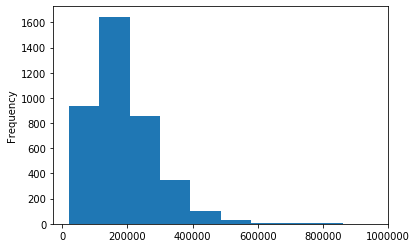

In [30]:
data["fnlwgt"].plot(kind="hist")
data["fnlwgt"].describe()

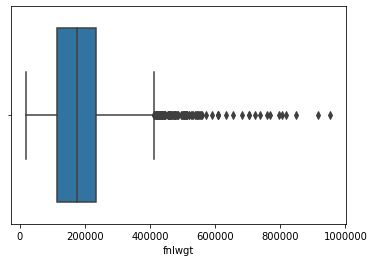

In [31]:
sns.boxplot('fnlwgt', data=data)

Ako môžeme vidieť, v tomto prípade sa outliery vyskytujú a to v hodnotách od cca 600000 do max, ktoré je 953588. Vychýlené hodnoty nahradíme 95 percentilom.

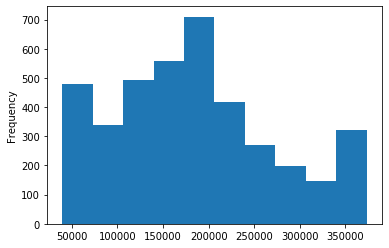

In [32]:
class OutlierClipper(TransformerMixin):
    
    def __init__(self, cols, up=0.95, low=0.05):
        self.cols=cols
        self.up=up
        self.low=low
        
    def fit(self, df, y=None):
        self.upper={}
        self.lower={}
        for col in self.cols:
            self.upper[col]=df[col].quantile(self.up)
            self.lower[col]=df[col].quantile(self.low)
        return self
    
    def transform(self, df, y=None):
        df=df.copy()
        for col in self.cols:
            df[col]=df[col].clip(upper=self.upper[col], lower=self.lower[col])
        return df

data=OutlierClipper(["fnlwgt"]).fit_transform(data)
data["fnlwgt"].plot(kind="hist")

## Agregované hodnoty cukru v krvi

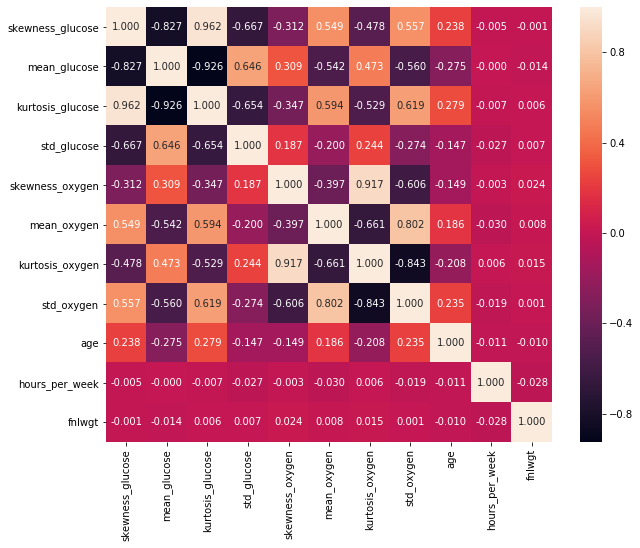

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data[['skewness_glucose', 'mean_glucose','kurtosis_glucose','std_glucose','skewness_oxygen', 'mean_oxygen','kurtosis_oxygen','std_oxygen','age','hours_per_week','fnlwgt']].corr(), ax=ax, annot=True, fmt=".3f")

Spravili sme si heat mapu, aby sme videli, čo môže vyplývať na náš atribút a zvolili sme si, že budeme priraďovať priemer z ľudí, ktorí majú rovnaký vek, pretože je vidieť, že jemne koreluje s našimi atribútmi, či už jedným alebo druhým smerom.

### skewness

In [34]:
data["skewness_glucose"].isnull().sum()

1

TODO: nahradit priemerom zo segmentu

In [35]:

df = data[data["skewness_glucose"].isnull()]
dfAge = df.iloc[0]['age']
df_fill = data.loc[data["age"] == dfAge]
fillAvg = df_fill['skewness_glucose'].mean()
data.fillna({'skewness_glucose':fillAvg}, inplace = True)


count    3933.000000
mean        4.219730
std         9.677885
min        -1.755332
25%        -0.119347
50%         0.375487
75%         2.090761
max        68.101622
Name: skewness_glucose, dtype: float64

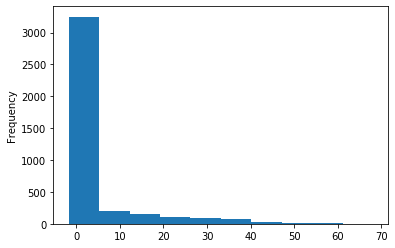

In [36]:
data["skewness_glucose"].plot(kind="hist")
data["skewness_glucose"].describe()

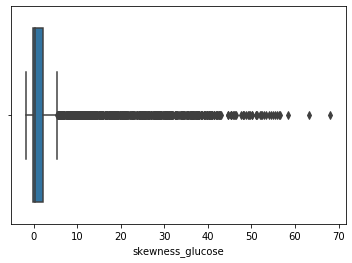

In [37]:
sns.boxplot('skewness_glucose', data=data)

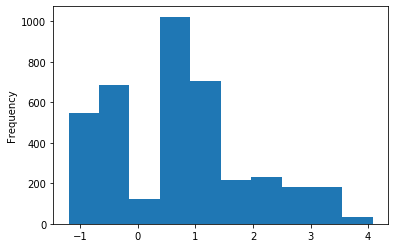

In [38]:

df = np.cbrt(data["skewness_glucose"])
df.plot(kind="hist")

Údaje v tomto stĺpci sme prentransformovali podľa tretej odmocniny.

### mean

In [39]:
data["mean_glucose"].isnull().sum()

0

count    3933.000000
mean      101.277271
std        33.560209
min         6.187500
25%        87.742188
50%       110.664062
75%       124.132812
max       189.734375
Name: mean_glucose, dtype: float64

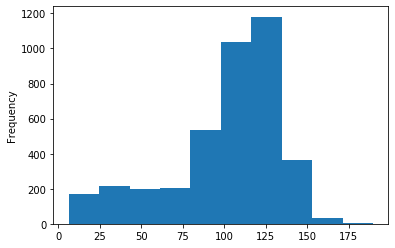

In [40]:
data["mean_glucose"].plot(kind="hist")
data["mean_glucose"].describe()

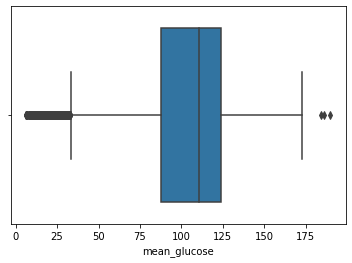

In [41]:
sns.boxplot('mean_glucose', data=data)

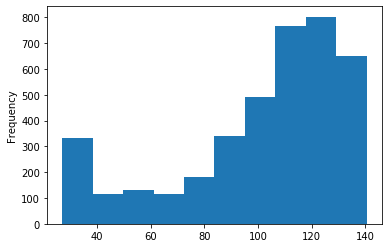

In [42]:
data=OutlierClipper(["mean_glucose"]).fit_transform(data)

data["mean_glucose"].plot(kind="hist")

### kurtosis

In [43]:
data["kurtosis_glucose"].isnull().sum()

1

In [44]:
df = data[data["kurtosis_glucose"].isnull()]
dfAge = df.iloc[0]['age']
df_fill = data.loc[data["age"] == dfAge]
fillAvg = df_fill['kurtosis_glucose'].mean()
data.fillna({'kurtosis_glucose':fillAvg}, inplace = True)


count    3933.000000
mean        0.951394
std         1.610959
min        -1.641515
25%         0.072144
50%         0.310784
75%         0.778607
max         8.069522
Name: kurtosis_glucose, dtype: float64

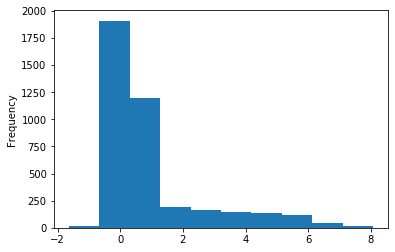

In [45]:
data["kurtosis_glucose"].plot(kind="hist")
data["kurtosis_glucose"].describe()

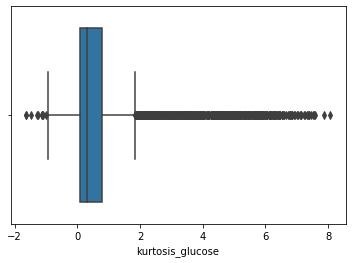

In [46]:
sns.boxplot('kurtosis_glucose', data=data)

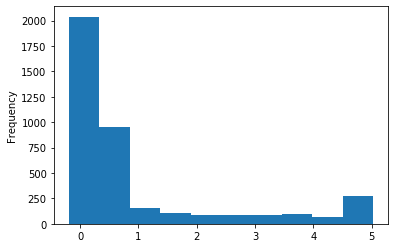

In [47]:
data=OutlierClipper(["kurtosis_glucose"]).fit_transform(data)
data["kurtosis_glucose"].plot(kind="hist")

### std

In [48]:
data["std_glucose"].isnull().sum()

0

count    3933.000000
mean       45.174684
std         7.607881
min        25.695250
25%        40.165726
50%        45.887420
75%        50.369068
max        91.206475
Name: std_glucose, dtype: float64

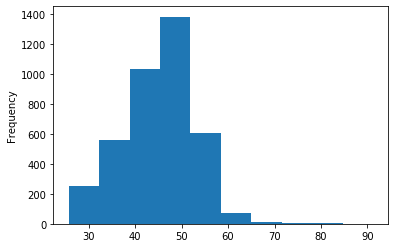

In [49]:
data["std_glucose"].plot(kind="hist")
data["std_glucose"].describe()

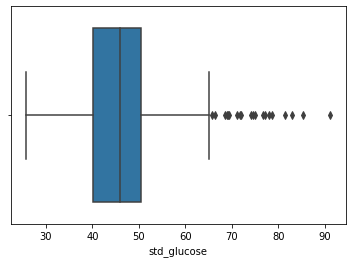

In [50]:
sns.boxplot('std_glucose', data=data)

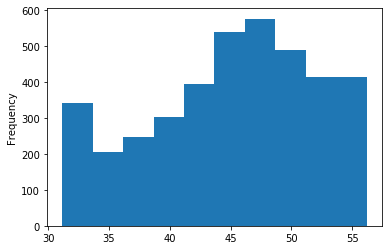

In [51]:
data=OutlierClipper(["std_glucose"]).fit_transform(data)
data["std_glucose"].plot(kind="hist")

## hours_per_week

In [52]:
data["hours_per_week"].isnull().sum()

0

count    3933.000000
mean       40.129672
std        12.103234
min         1.000000
25%        40.000000
50%        40.000000
75%        45.000000
max        99.000000
Name: hours_per_week, dtype: float64

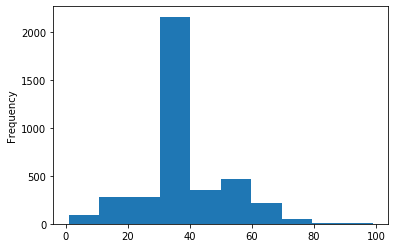

In [53]:
data["hours_per_week"].plot(kind="hist")
data["hours_per_week"].describe()

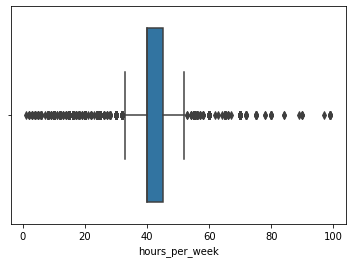

In [54]:
sns.boxplot('hours_per_week', data=data)

Nepamatas sa, co nam hovoril s tymto, ze co robit, ked tam niekto tych 99 hodin, ci to nechat alebo co?

## Agregovane hodnoty kyslika

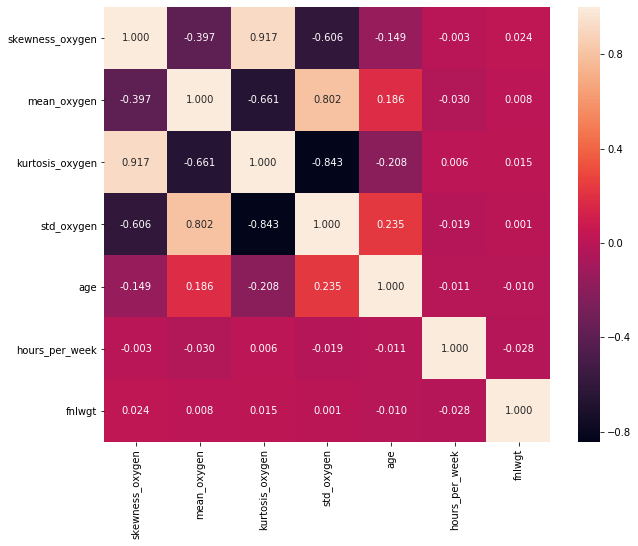

In [55]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data[['skewness_oxygen', 'mean_oxygen','kurtosis_oxygen','std_oxygen','age','hours_per_week','fnlwgt']].corr(), ax=ax, annot=True, fmt=".3f")

Z heat mapy je možné vidieť, že hodnoty kyslíka jemne korelujú s vekom. Preto v niektorých atribútoch pri nahrádzaní budeme brať vek na ohľad.

### skewness

In [56]:
data["skewness_oxygen"].isnull().sum()

1

In [57]:
data.fillna({'skewness_oxygen':data['skewness_oxygen'].mean()}, inplace = True)

Chýbajúcu hodnotu nahradíme celkovým priemerom zo vzorky.

count    3933.000000
mean       91.297976
std       108.552002
min        -1.976976
25%        12.866679
50%        68.490474
75%       127.012005
max      1191.000837
Name: skewness_oxygen, dtype: float64

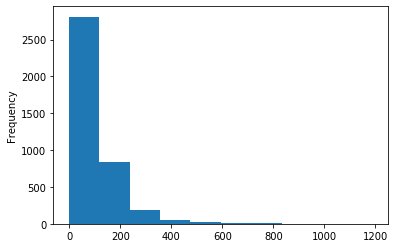

In [58]:
data["skewness_oxygen"].plot(kind="hist")
data["skewness_oxygen"].describe()

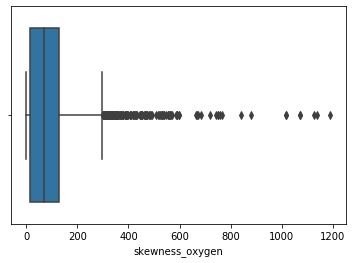

In [59]:
sns.boxplot('skewness_oxygen', data=data)

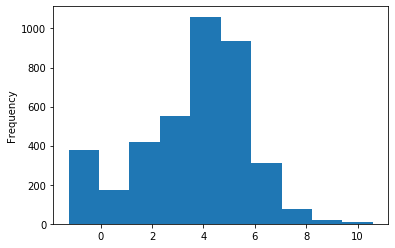

In [60]:
data["skewness_oxygen"]= np.cbrt(data["skewness_oxygen"])
data["skewness_oxygen"].plot(kind="hist")

Hodnoty v stĺpcoch sme pretransformovali podľa tretej odmocniny.

### mean

In [61]:
data["mean_oxygen"].isnull().sum()

1

In [62]:
df = data[data["mean_oxygen"].isnull()]
dfAge = df.iloc[0]['age']
df_fill = data.loc[data["age"] == dfAge]
fillAvg = df_fill['mean_oxygen'].mean()
data.fillna({'mean_oxygen':fillAvg}, inplace = True)


count    3933.000000
mean       18.482930
std        34.788613
min         0.213211
25%         2.065217
50%         3.236622
75%        12.647993
max       217.371238
Name: mean_oxygen, dtype: float64

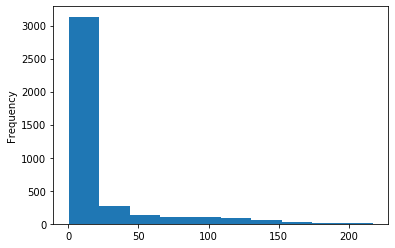

In [63]:
data["mean_oxygen"].plot(kind="hist")
data["mean_oxygen"].describe()

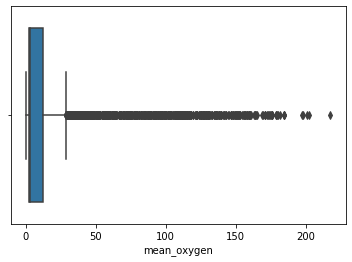

In [64]:
sns.boxplot('mean_oxygen', data=data)

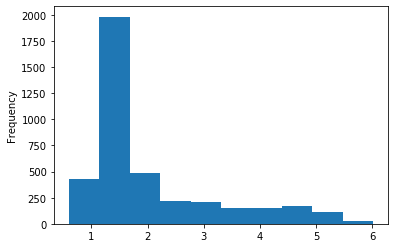

In [65]:
data["mean_oxygen"]= np.cbrt(data["mean_oxygen"])
data["mean_oxygen"].plot(kind="hist")

Hodnoty sme opat pretransformovali podla tretej odmocniny.

### kurtosis

In [66]:
data["kurtosis_oxygen"].isnull().sum()

1

In [67]:
data.fillna({'kurtosis_oxygen':data['kurtosis_oxygen'].mean()}, inplace = True)

count    3933.000000
mean        7.413030
std         4.812078
min        -2.597872
25%         3.637833
50%         7.781618
75%        10.261581
max        34.539844
Name: kurtosis_oxygen, dtype: float64

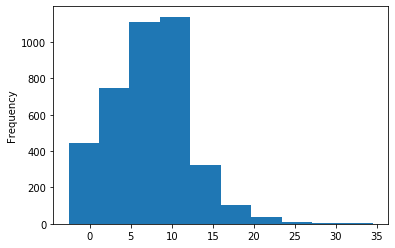

In [68]:
data["kurtosis_oxygen"].plot(kind="hist")
data["kurtosis_oxygen"].describe()

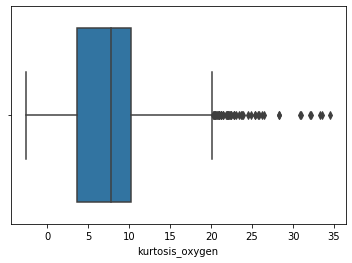

In [69]:
sns.boxplot('kurtosis_oxygen', data=data)

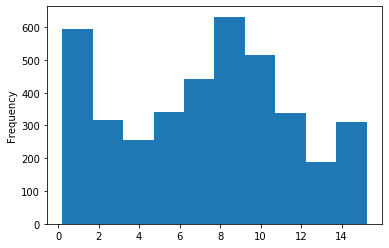

In [70]:
data=OutlierClipper(["kurtosis_oxygen"]).fit_transform(data)

data["kurtosis_oxygen"].plot(kind="hist")

### std

In [71]:
data["std_oxygen"].isnull().sum()

1

In [72]:
df = data[data["std_oxygen"].isnull()]
dfAge = df.iloc[0]['age']
df_fill = data.loc[data["age"] == dfAge]
fillAvg = df_fill['std_oxygen'].mean()
data.fillna({'std_oxygen':fillAvg}, inplace = True)

count    3933.000000
mean       31.158014
std        22.266866
min         7.370432
25%        15.040684
50%        20.567593
75%        43.221350
max       110.642211
Name: std_oxygen, dtype: float64

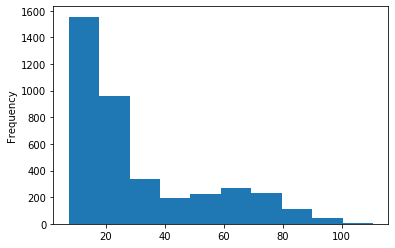

In [73]:
data["std_oxygen"].plot(kind="hist")
data["std_oxygen"].describe()

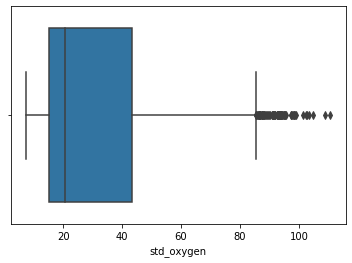

In [74]:
sns.boxplot('std_oxygen', data=data)

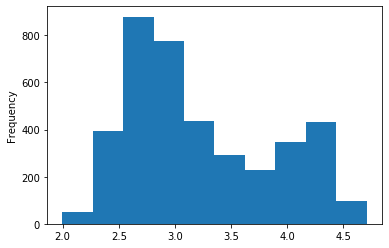

In [75]:
data["std_oxygen"]= np.log(data["std_oxygen"])
data["std_oxygen"].plot(kind="hist")

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 25 columns):
state                3933 non-null object
age                  3933 non-null float64
male                 3933 non-null float64
birth_month          3933 non-null float64
race                 3932 non-null object
marital_status       3540 non-null object
occupation           3695 non-null object
pregnant             3933 non-null float64
relationship         3933 non-null object
skewness_glucose     3933 non-null float64
mean_glucose         3933 non-null float64
capital              3933 non-null float64
kurtosis_glucose     3933 non-null float64
education            3933 non-null float64
fnlwgt               3933 non-null float64
class                3933 non-null float64
std_glucose          3933 non-null float64
income_over_fifty    3932 non-null float64
native_country       3852 non-null object
hours_per_week       3933 non-null float64
workclass            3695 non-null obje

# Znovupoužitelnosť predspracovania

pod tento nadpis urobit tu znovu pouzitelnost...pouzivame na doplnenie priemer, resp. priemer zo segmentu podla veku, na vyriesenie outlierov bud nahradime len 95 percentil alebo aj 5 + niektore atributy transformujeme podla 3. odmocniny, resp. logaritmu.


# Opätovná realizácia podstatných častí prieskumnej analýzy


V tejto časti sa zameriame najmä na atribúty, ktoré sú pre nás nové (agregované hodnoty kyslíka, birth_month) alebo tie, ktoré sme zmenili radikálnejším spôsobom (education). Dalej si zobrazime heatmapu aj s novymi atributmi a zanalyzujeme nove korelacie. 

### education

9.0     1261
10.0     904
13.0     657
14.0     207
11.0     151
12.0     135
7.0      122
6.0      113
4.0       92
15.0      68
5.0       63
8.0       47
16.0      45
3.0       45
2.0       13
1.0       10
Name: education, dtype: int64

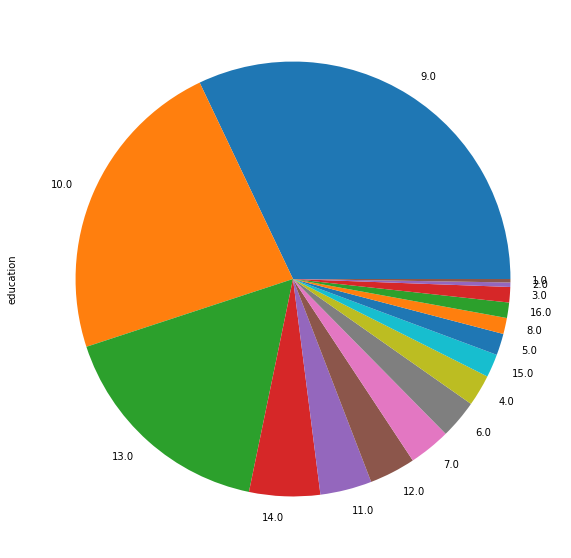

In [77]:
data["education"].value_counts().plot(kind='pie', figsize=(15,10))
data["education"].value_counts(dropna=False)
# po zjednoteni na 1.stupen, druhy, SS, VS a tak urobit znova

## Agregovane hodnoty kyslika

s tymito hodnotami sme uz pracovali, chybajuce udaje sme nahradili bud priemerom alebo priemerom zo segmentu (rovnaky vek).
Tieto atributy su uz bez oulierov, bud sme ich nahradili percentilo alebo pretransformovali podla tretej odmocniny, resp. logaritmu.

### skewness

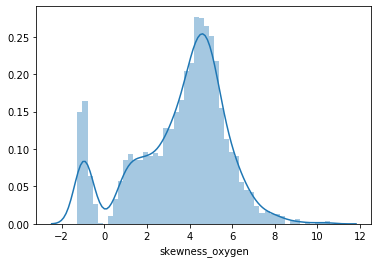

In [78]:
data["skewness_oxygen"].value_counts(dropna=False)
skew = data["skewness_oxygen"].fillna(axis=0, method='ffill')
ax = sns.distplot(skew,bins=50)

In [79]:
data["skewness_oxygen"].describe()

count    3933.000000
mean        3.599601
std         2.155236
min        -1.255068
25%         2.343269
50%         4.091445
75%         5.026684
max        10.599955
Name: skewness_oxygen, dtype: float64

Vidime, ze najviac hodnot sa hybe okolo 4, maximum je nad 10 a minimum je v cca -1.

### mean

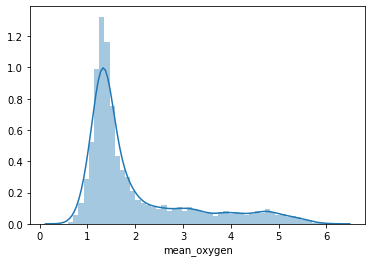

In [80]:
data["mean_oxygen"].value_counts(dropna=False)
skew = data["mean_oxygen"].fillna(axis=0, method='ffill')
ax = sns.distplot(skew,bins=50)

In [81]:
data["mean_oxygen"].describe()

count    3933.000000
mean        2.007724
std         1.155711
min         0.597406
25%         1.273470
50%         1.479213
75%         2.329917
max         6.012670
Name: mean_oxygen, dtype: float64

Tu vidime, ze atribut je po transformacii v peknom longtail rozdeleni, s medianom 1,4.

### kurtosis

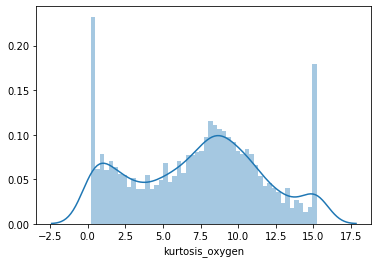

In [82]:
data["kurtosis_oxygen"].value_counts(dropna=False)

ax = sns.distplot(data["kurtosis_oxygen"],bins=50)

count    3933.000000
mean        7.261150
std         4.285676
min         0.202820
25%         3.637833
50%         7.781618
75%        10.261581
max        15.240830
Name: kurtosis_oxygen, dtype: float64

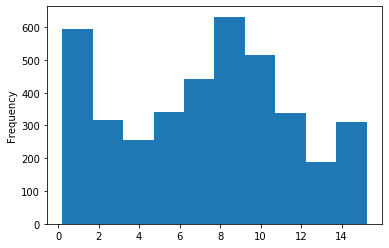

In [83]:
data["kurtosis_oxygen"].plot(kind="hist")
data["kurtosis_oxygen"].describe()

Na zaklade tychto grafov je mozne vidiet, ze najviac hodnot je okolo 8-10.

### std

count    3933.000000
mean        3.219952
std         0.639663
min         1.997476
25%         2.710759
50%         3.023717
75%         3.766335
max         4.706302
Name: std_oxygen, dtype: float64

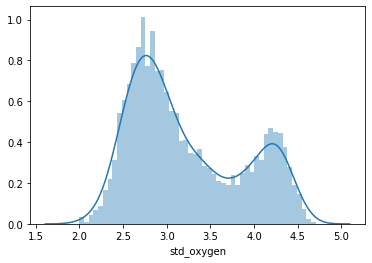

In [84]:
ax = sns.distplot(data["std_oxygen"],bins=50)
data["std_oxygen"].describe()

Tu vidime, ze vela hodnot je medzi 2.5 a 3 a potom mensi vrchol je medzi 4 a 4.5.

## birth_month

12.0    362
5.0     356
4.0     339
11.0    338
9.0     334
6.0     330
3.0     328
10.0    324
7.0     319
8.0     315
1.0     309
2.0     279
Name: birth_month, dtype: int64

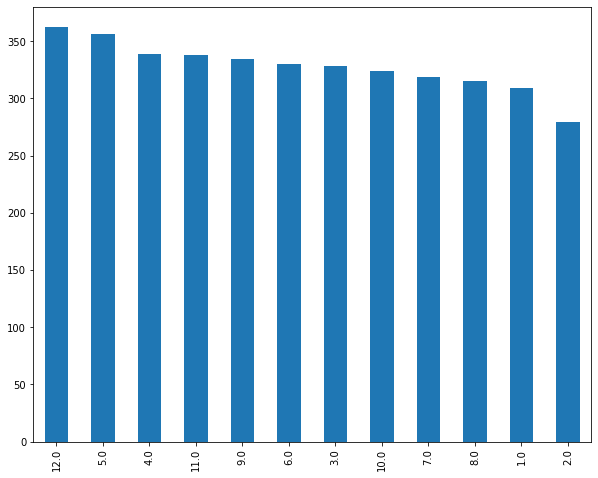

In [85]:
data["birth_month"].value_counts().plot(kind='bar', figsize=(10,8))
data["birth_month"].value_counts(dropna=False)

Vidíme, že ľudia sú prevažne narovnako rozdelení do každého mesiaca roka.

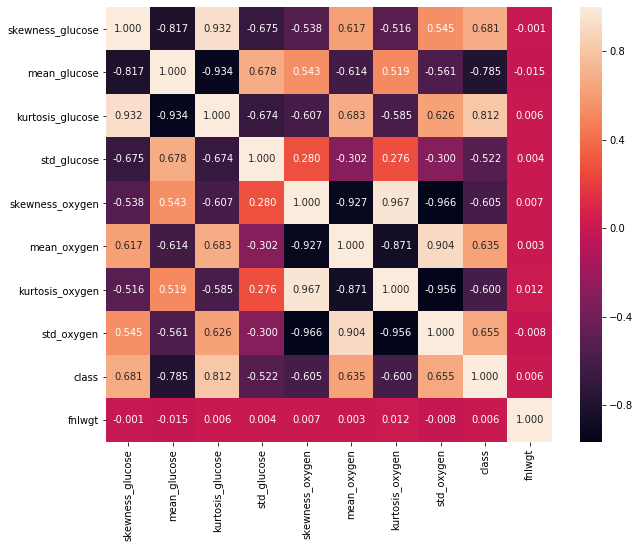

In [86]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data[['skewness_glucose', 'mean_glucose','kurtosis_glucose','std_glucose','skewness_oxygen', 'mean_oxygen','kurtosis_oxygen','std_oxygen','class','fnlwgt']].corr(), ax=ax, annot=True, fmt=".3f")

Na heatmape zobrazujeme, len medicinske atributy (hodnoty kyslika a cukru), kedze heatmapa z prvej etapy nam ukazala, ze ostatne atributy nemaju takmer ziadny vplyv. vid. heat mapa pod touto bunkou.
Pri pohlada na tuto heatmapu je zrejme, že agregovane hodnoty kyslika mozu sluzit ako prediktory pre atribut class a v porovnani s hodnotami cukru su sposoby korelacie presne opacne (v hodnotach cukru maju priamu umeru skewness a kurtosis a nepriamu mean a std a v hodnotach kysliku je to naopak).


Heatmapa z prvej etapy, kde vidno, že ostatné nami zvolené atribúty majú zanedbateľný vplyv:

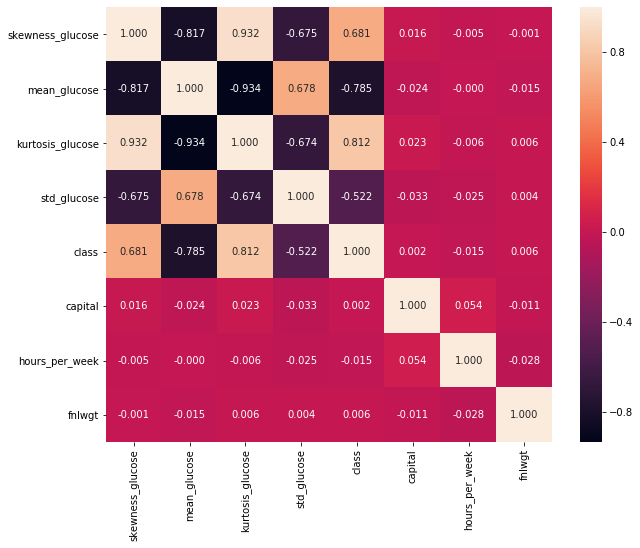

In [87]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data[['skewness_glucose', 'mean_glucose','kurtosis_glucose','std_glucose','class','capital','hours_per_week','fnlwgt']].corr(), ax=ax, annot=True, fmt=".3f")

TODO:
- zmenit stringove atributy na boolean resp. dictionary
- doplnit marital-status cez relationship
- prieskumna analyza pre oxygeny, education, age, birth_month
- znovupouzitelnost






In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 25 columns):
state                3933 non-null object
age                  3933 non-null float64
male                 3933 non-null float64
birth_month          3933 non-null float64
race                 3932 non-null object
marital_status       3540 non-null object
occupation           3695 non-null object
pregnant             3933 non-null float64
relationship         3933 non-null object
skewness_glucose     3933 non-null float64
mean_glucose         3933 non-null float64
capital              3933 non-null float64
kurtosis_glucose     3933 non-null float64
education            3933 non-null float64
fnlwgt               3933 non-null float64
class                3933 non-null float64
std_glucose          3933 non-null float64
income_over_fifty    3932 non-null float64
native_country       3852 non-null object
hours_per_week       3933 non-null float64
workclass            3695 non-null obje